In [1]:
import theano.tensor as T
import numpy as np
import theano


ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 60, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu/gpuarray.pyx", line 614, in pygpu.gpuarray.init (pygpu/gpuarray.c:9415)
  File "pygpu/gpuarray.pyx", line 566, in pygpu.gpuarray.pygpu_init (pygpu/gpuarray.c:9106)
  File "pygpu/gpuarray.pyx", line 1021, in pygpu.gpuarray.GpuContext.__cinit__ (pygpu/gpuarray.c:13468)
GpuArrayException: Unknown device error: -1


In [2]:
from lasagne import layers as L

In [116]:
def pack_mcw(m,c,w):
    '''
    m = batch,gm_num,dim
    c = batch,gm_num
    w = batch,gm_num
    ''' 
    return T.concatenate([m,c.reshape((c.shape[0],c.shape[1],1)),w.reshape((w.shape[0],w.shape[1],1))],2)
    
def unpack_mcw(mcw):
    '''
    mcw = batch,gm_num,[ndim,c,w]
    return  m = batch,gm_num,dim
            c = batch,gm_num
            w = batch,gm_num
    ''' 
    return mcw[:,:,:-2],mcw[:,:,-2],mcw[:,:,-1]

def iterative_update(m,c,w,m0,c0,w0,eps=1e-10):
    '''
    m = batch,gm_num,dim
    c = batch,gm_num
    w = batch,gm_num
    m0 = batch,dim
    c0 = batch
    w0 = batch
    return m,c,w
    ''' 
    #add component correspoding to X
    m0 = m0.reshape((m0.shape[0],1,m0.shape[1]))
    m = T.concatenate((m,m0),1)
    c = T.concatenate((c,c0.reshape((c0.shape[0],1))),1)
    w = T.concatenate((w,w0.reshape((w0.shape[0],1))),1)
    w = w/T.sum(w,1)[:,None]
    
    #split components
    dist = m[:,:,None,:]-m[:,None,:,:]
    dist = T.sum(T.square(dist),-1)*w[:,None,:]*w[:,:,None]
    batched_eye = T.zeros_like(dist)+T.eye(dist.shape[1],dtype=dist.dtype)[None,:,:]
    dist = dist+batched_eye*dist.max()
    dist = T.min(dist,-1)
    inx = T.argsort(dist,-1)
    inx += (T.arange(0,dist.shape[0],dtype=inx.dtype)*dist.shape[1])[:,None]
    inx = inx.flatten()
    m = m.reshape((m.shape[0]*m.shape[1],m.shape[2]))[inx].reshape(m.shape)
    c = c.flatten()[inx].reshape(c.shape)
    w = w.flatten()[inx].reshape(w.shape)
    
    m0 = m[:,:2,:]
    c0 = c[:,:2]
    w0 = w[:,:2]
    
    m = m[:,2:,:]
    c = c[:,2:]
    w = w[:,2:]
    
    #merge components
    ww =w0/T.sum(w0,-1)[:,None]
    _m0 = T.sum(m0*ww[:,:,None],1,keepdims=True)
    _c0 = T.sum((c0+T.sum(T.square(_m0-m0),-1))*ww,1,keepdims=True)
    _w0 = T.sum(w0,1,keepdims=True)
    
    m = T.concatenate([m,_m0],1)
    c = T.concatenate([c,_c0],1)
    w = T.concatenate([w,_w0],1)
    return m,c,w


def componentwise_score_gmm(X,m,c,eps=1e-7):
    '''
    calculate loglikelihood for each gaussian in mixture
    X - batch,samples,dim
    m - batch,gm_num,dim
    c - batch,gm_num
    w - batch,gm_num
    return tensor3 batch,samples,gm_num
    '''
    dist = T.sum(T.square(X[:,:,None,:] - m[:,None,:,:]),-1)/(c[:,None,:]+eps)
    norm = (T.log(2.*np.pi)+c)*X.shape[-1]
    return -0.5*(norm[:,None,:]+dist)

def score_gmm(X,m,c,w,eps=1e-7):
    '''
    calculate loglikelihood for gaussian mixture
    X - batch,samples,dim
    m - batch,gm_num,dim
    c - batch,gm_num
    w - batch,gm_num
    return matrix batch,samples
    '''
    lprob = componentwise_score_gmm(X,m,c,eps)+T.log(w+eps)[:,None,:]
    lmax = T.max(lprob,-1)
    return T.log(T.sum(T.exp(lprob-lmax[:,:,None]),-1)+1e-10)+lmax

        
# X,m,c,w,c0,w0 = T.matrix(),T.tensor3(),T.matrix(),T.matrix(),T.vector(),T.vector()
# iu  =iterative_update(m,c,w,X,c0,w0)
# f = theano.function([X,m,c,w,c0,w0],iu,allow_input_downcast=True)

In [118]:

class ScoreGMMLayer(L.MergeLayer):
    '''
    calculate loglikelihood for gaussian mixture
    X - batch,samples,dim
    mcw - batch,gm_num,dim+2
    return matrix batch,samples
    '''
    def __init__(self,X,mcw,eps=1e-7,name="score_gmm",**kwargs):
        super(ScoreGMMLayer,self).__init__([X,mcw],name=name,**kwargs)
        self.eps=eps
        
    def get_output_shape_for(self,input_shape):
        assert(len(input_shape[0]) == 3)
        assert(len(input_shape[1]) == 3)
        assert(input_shape[0][0] == input_shape[1][0] and input_shape[0][2]+2 == input_shape[1][2])
        return input_shape[0][:2]
        
    def get_output_for(self, input, **kwargs):
        m,c,w = unpack_mcw(input[1])
        X = input[0]
        return score_gmm(X,m,c,w,self.eps)

class UpdateGMMLayer(L.MergeLayer):
    '''
    update gmm parameters
    Xcw - batch,dim+2
    mcw - batch,gm_num,dim+2
    
    '''
    def __init__(self,Xcw,mcw,eps=1e-7,name="update_gmm",**kwargs):
        super(UpdateGMMLayer,self).__init__([Xcw,mcw],name=name,**kwargs)
        self.eps = eps
        
    def get_output_shape_for(self,input_shape):
        assert(len(input_shape[1]) == 3)
        assert(len(input_shape[0]) == 2)
        assert(input_shape[1][0] == input_shape[0][0] and input_shape[0][1] == input_shape[1][2])
        return input_shape[1]
        
    def get_output_for(self, input, **kwargs):
        m,c,w = unpack_mcw(input[1])
        X = input[0]
        m0 = X[:,:-2]
        c0 = X[:,-2]
        w0 = X[:,-1]
        m,c,w = iterative_update(m,c,w,m0,c0,w0,self.eps) 
        return pack_mcw(m,c,w)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
def gen_mixture(ns,dim,sigm=.3):
    ns = np.array(ns)
    means = []
    covs = []
    weights = ns.astype(np.float32)/ns.sum()
    res = np.zeros((int(sum(ns)),dim),dtype=np.float32)
    i = 0
    for n in ns:
        covs.append(sigm*(np.random.rand(dim)+1.))
        means.append(10*(np.random.rand(dim)))
        res[i:i+n] = np.random.randn(n,dim)*covs[-1][None,:]+means[-1][None,:]
        covs[-1] = np.std(res[i:i+n],0)**2
        means[-1] = np.mean(res[i:i+n],0)
        i=i+n
    return res,np.array(means),np.array(covs),weights

X,tm,tc,tw = gen_mixture([200,300,200,100],2,0.3)

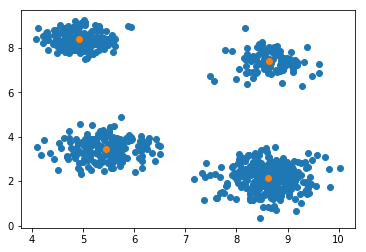

In [71]:
plt.plot(X[:,0],X[:,1],'o')
plt.plot(tm[:,0],tm[:,1],'o')

In [72]:
np.random.shuffle(X)

L.get_output()

In [73]:
m = X[:4].reshape((1,4,-1))
c = np.ones((1,4))*0.1
w = np.ones((1,4))*0.25
for i in range(4,len(X)):
    m,c,w = f(X[i].reshape((1,-1)),m,c,w,np.array([0.01]),np.array([0.1]))

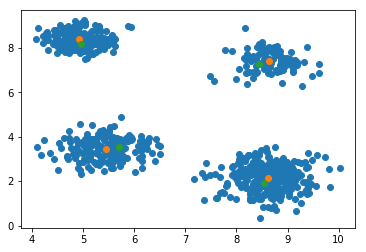

In [74]:
plt.plot(X[:,0],X[:,1],'o')
plt.plot(tm[:,0],tm[:,1],'o')

#plt.plot(X[:20,0],X[:20,1],'o')
plt.plot(m[0,:,0],m[0,:,1],'o')


In [75]:
w

array([[ 0.16262268,  0.05669099,  0.27801654,  0.50266981]], dtype=float32)

In [119]:
import lasagne

class MyRecurrentLayer(L.MergeLayer):
    """
    MyRecurrentLayer(incoming, input_to_hidden,
    hid_init=lasagne.init.Constant(0.), backwards=False,
    learn_init=False, gradient_steps=-1, grad_clipping=0,
    unroll_scan=False, mask_input=None,
    only_return_final=False, **kwargs)
    A layer which implements a recurrent connection.
    This layer allows you to specify custom input-to-hidden
    input-to-hidden must have 2 input layers, one with name hidden correspods to hidden parameters
    X_n+1 = input-to-hidden(X_n,H_n)
    Parameters
    ----------
    incoming : a :class:`lasagne.layers.Layer` instance or a tuple
        The layer feeding into this layer, or the expected input shape.
    input_to_hidden : :class:`lasagne.layers.Layer`
        :class:`lasagne.layers.Layer` instance which connects input to the
        hidden state (:math:`f_i`).  This layer may be connected to a chain of
        layers, which must end in a :class:`lasagne.layers.InputLayer` with the
        same input shape as `incoming`, except for the first dimension: When
        ``precompute_input == True`` (the default), it must be
        ``incoming.output_shape[0]*incoming.output_shape[1]`` or ``None``; when
        ``precompute_input == False``, it must be ``incoming.output_shape[0]``
        or ``None``.
    hid_init : callable, np.ndarray, theano.shared or :class:`Layer`
        Initializer for initial hidden state (:math:`h_0`).
    backwards : bool
        If True, process the sequence backwards and then reverse the
        output again such that the output from the layer is always
        from :math:`x_1` to :math:`x_n`.
    learn_init : bool
        If True, initial hidden values are learned.
    gradient_steps : int
        Number of timesteps to include in the backpropagated gradient.
        If -1, backpropagate through the entire sequence.
    grad_clipping : float
        If nonzero, the gradient messages are clipped to the given value during
        the backward pass.  See [1]_ (p. 6) for further explanation.
    unroll_scan : bool
        If True the recursion is unrolled instead of using scan. For some
        graphs this gives a significant speed up but it might also consume
        more memory. When `unroll_scan` is True, backpropagation always
        includes the full sequence, so `gradient_steps` must be set to -1 and
        the input sequence length must be known at compile time (i.e., cannot
        be given as None).
    mask_input : :class:`lasagne.layers.Layer`
        Layer which allows for a sequence mask to be input, for when sequences
        are of variable length.  Default `None`, which means no mask will be
        supplied (i.e. all sequences are of the same length).
    only_return_final : bool
        If True, only return the final sequential output (e.g. for tasks where
        a single target value for the entire sequence is desired).  In this
        case, Theano makes an optimization which saves memory.
    """
    def __init__(self, incoming, input_to_hidden, 
                 hid_init=lasagne.init.Constant(0.),
                 backwards=False,
                 learn_init=False,
                 gradient_steps=-1,
                 grad_clipping=0,
                 unroll_scan=False,
                 mask_input=None,
                 only_return_final=False,
                 **kwargs):

        # This layer inherits from a MergeLayer, because it can have three
        # inputs - the layer input, the mask and the initial hidden state.  We
        # will just provide the layer input as incomings, unless a mask input
        # or initial hidden state was provided.
        incomings = [incoming]
        self.mask_incoming_index = -1
        self.hid_init_incoming_index = -1
        if mask_input is not None:
            incomings.append(mask_input)
            self.mask_incoming_index = len(incomings)-1
        if isinstance(hid_init, L.Layer):
            incomings.append(hid_init)
            self.hid_init_incoming_index = len(incomings)-1

        super(MyRecurrentLayer, self).__init__(incomings, **kwargs)

        input_to_hidden_in_layers = \
            [layer for layer in L.get_all_layers(input_to_hidden)
             if isinstance(layer, L.InputLayer)]
        if len(input_to_hidden_in_layers) != 2:
            raise ValueError(
                '`input_to_hidden` must have exactly two InputLayer, but it '
                'has {}'.format(len(input_to_hidden_in_layers)))
            
        self.input_to_hidden_input = [ i for i in input_to_hidden_in_layers if i.name != 'hidden'][0]
        self.input_to_hidden_hidden = [ i for i in input_to_hidden_in_layers if i.name == 'hidden']
        if(len(self.input_to_hidden_hidden) != 1):
            raise ValueError(
                '`input_to_hidden` must have exactly one InputLayer with name hidden, but it '
                'has {}'.format(len(self.input_to_hidden_hidden)))
        else:
            self.input_to_hidden_hidden = self.input_to_hidden_hidden[0]
            
        self.input_to_hidden = input_to_hidden
        self.learn_init = learn_init
        self.backwards = backwards
        self.gradient_steps = gradient_steps
        self.grad_clipping = grad_clipping
        self.unroll_scan = unroll_scan
        self.only_return_final = only_return_final

        if unroll_scan and gradient_steps != -1:
            raise ValueError(
                "Gradient steps must be -1 when unroll_scan is true.")

        # Retrieve the dimensionality of the incoming layer
        input_shape = self.input_shapes[0]

        if unroll_scan and input_shape[1] is None:
            raise ValueError("Input sequence length cannot be specified as "
                             "None when unroll_scan is True")

        

        # Check that input_to_hidden and hidden_to_hidden output shapes match,
        # but don't check a dimension if it's None for either shape
        if not all(s1 is None or s2 is None or s1 == s2
                   for s1, s2 in zip(input_to_hidden.output_shape[1:],
                                     self.input_to_hidden_hidden.shape[1:])):
            raise ValueError("The output shape for input_to_hidden and "
                             "input shape for hidden must be equal after the first "
                             "dimension, but input_to_hidden.output_shape={} "
                             "and input_to_hidden_hidden.shape={}".format(
                                 input_to_hidden.output_shape,
                                 self.input_to_hidden_hidden.shape))

        # Initialize hidden state
        if isinstance(hid_init, L.Layer):
            self.hid_init = hid_init
        else:
            self.hid_init = self.add_param(
                hid_init, (1,) + input_to_hidden.output_shape[1:],
                name="hid_init", trainable=learn_init, regularizable=False)

    def get_params(self, **tags):
        # Get all parameters from this layer, the master layer
        params = super(MyRecurrentLayer, self).get_params(**tags)
        # Combine with all parameters from the child layers
        params += L.get_all_params(self.input_to_hidden, **tags)
        return params

    def get_output_shape_for(self, input_shapes):
        # The shape of the input to this layer will be the first element
        # of input_shapes, whether or not a mask input is being used.
        input_shape = input_shapes[0]
        # When only_return_final is true, the second (sequence step) dimension
        # will be flattened
        if self.only_return_final:
            return (input_shape[0],) + self.input_to_hidden.output_shape[1:]
        # Otherwise, the shape will be (n_batch, n_steps, trailing_dims...)
        else:
            return ((input_shape[0], input_shape[1]) +
                    self.input_to_hidden.output_shape[1:])

    def get_output_for(self, inputs, **kwargs):
        """
        Compute this layer's output function given a symbolic input variable.
        Parameters
        ----------
        inputs : list of theano.TensorType
            `inputs[0]` should always be the symbolic input variable.  When
            this layer has a mask input (i.e. was instantiated with
            `mask_input != None`, indicating that the lengths of sequences in
            each batch vary), `inputs` should have length 2, where `inputs[1]`
            is the `mask`.  The `mask` should be supplied as a Theano variable
            denoting whether each time step in each sequence in the batch is
            part of the sequence or not.  `mask` should be a matrix of shape
            ``(n_batch, n_time_steps)`` where ``mask[i, j] = 1`` when ``j <=
            (length of sequence i)`` and ``mask[i, j] = 0`` when ``j > (length
            of sequence i)``. When the hidden state of this layer is to be
            pre-filled (i.e. was set to a :class:`Layer` instance) `inputs`
            should have length at least 2, and `inputs[-1]` is the hidden state
            to prefill with.
        Returns
        -------
        layer_output : theano.TensorType
            Symbolic output variable.
        """
        # Retrieve the layer input
        input = inputs[0]
        # Retrieve the mask when it is supplied
        mask = None
        hid_init = None
        if self.mask_incoming_index > 0:
            mask = inputs[self.mask_incoming_index]
        if self.hid_init_incoming_index > 0:
            hid_init = inputs[self.hid_init_incoming_index]

        # Input should be provided as (n_batch, n_time_steps, n_features)
        # but scan requires the iterable dimension to be first
        # So, we need to dimshuffle to (n_time_steps, n_batch, n_features)
        input = input.dimshuffle(1, 0, *range(2, input.ndim))
        seq_len, num_batch = input.shape[0], input.shape[1]

        # When we are not precomputing the input, we also need to pass the
        # input-to-hidden parameters to step
        non_seqs = L.get_all_params(self.input_to_hidden)

        # Create single recurrent computation step function
        def step(input_n, hid_previous, *args):
            hid_pre = L.get_output(
                    self.input_to_hidden,{self.input_to_hidden_input : input_n,
                                              self.input_to_hidden_hidden : hid_previous}, **kwargs)

            # Clip gradients
            if self.grad_clipping:
                hid_pre = theano.gradient.grad_clip(
                    hid_pre, -self.grad_clipping, self.grad_clipping)

            return hid_pre

        def step_masked(input_n, mask_n, hid_previous, *args):
            # Skip over any input with mask 0 by copying the previous
            # hidden state; proceed normally for any input with mask 1.
            hid = step(input_n, hid_previous, *args)
            hid_out = T.switch(mask_n, hid, hid_previous)
            return [hid_out]

        if mask is not None:
            mask = mask.dimshuffle(1, 0, 'x')
            sequences = [input, mask]
            step_fun = step_masked
        else:
            sequences = input
            step_fun = step

        if not isinstance(self.hid_init, L.Layer):
            # The code below simply repeats self.hid_init num_batch times in
            # its first dimension.  Turns out using a dot product and a
            # dimshuffle is faster than T.repeat.
            dot_dims = (list(range(1, self.hid_init.ndim - 1)) +
                        [0, self.hid_init.ndim - 1])
            hid_init = T.dot(T.ones((num_batch, 1)),
                             self.hid_init.dimshuffle(dot_dims))

        if self.unroll_scan:
            # Retrieve the dimensionality of the incoming layer
            input_shape = self.input_shapes[0]
            # Explicitly unroll the recurrence instead of using scan
            hid_out = unroll_scan(
                fn=step_fun,
                sequences=sequences,
                outputs_info=[hid_init],
                go_backwards=self.backwards,
                non_sequences=non_seqs,
                n_steps=input_shape[1])[0]
        else:
            # Scan op iterates over first dimension of input and repeatedly
            # applies the step function
            hid_out = theano.scan(
                fn=step_fun,
                sequences=sequences,
                go_backwards=self.backwards,
                outputs_info=[hid_init],
                non_sequences=non_seqs,
                truncate_gradient=self.gradient_steps,
                strict=True)[0]

        # When it is requested that we only return the final sequence step,
        # we need to slice it out immediately after scan is applied
        if self.only_return_final:
            hid_out = hid_out[-1]
        else:
            # dimshuffle back to (n_batch, n_time_steps, n_features))
            hid_out = hid_out.dimshuffle(1, 0, *range(2, hid_out.ndim))

            # if scan is backward reverse the output
            if self.backwards:
                hid_out = hid_out[:, ::-1]

        return hid_out

    
class InitHiddenLayer(L.Layer):
    '''
    input batch,samples,dims,...
    '''
    
    def __init__(self,incoming,C=lasagne.init.Constant(.1),**kwargs):
        super(InitHiddenLayer,self).__init__(incoming,**kwargs)
        self.C = self.add_param(C,(1,), 'C', trainable=True, regularizable=False)
        
    def get_output_shape_for(self,input_shape):
        return (input_shape[:2],input_shape[2]+2)+input_shape[2+1:]
        
    def get_output_for(self, input, **kwargs):
        c = T.zeros_like(input[:,:,:1,...])+self.C
        w = T.ones_like(input[:,:,:1,...])/input.shape[1]
        return T.concatenate([input,c,w],2)

In [6]:
from broadcast import BroadcastLayer,UnbroadcastLayer
from utils import get_network_str

In [144]:

def build_cw_net(data):
    c = L.Conv2DLayer(data,1,3,nonlinearity=lasagne.nonlinearities.softplus,name='cov',pad='same')
    w = L.Conv2DLayer(data,1,3,nonlinearity=lasagne.nonlinearities.sigmoid,name='weight',pad='same')
    return c,w
    
def build_input_to_hidden(gm_num,input_channels,features_tensor=None,hidden_tensor=None):
    features = L.InputLayer((10,input_channels,7,11),features_tensor,name='features')
    hidden = L.InputLayer((10,gm_num,features.output_shape[1]+2,7,11),hidden_tensor,name='hidden')
    bcast_hidden = BroadcastLayer(hidden,(0,3,4),name='bcast_hidden')
    bcast_features = BroadcastLayer(features,(0,2,3),name='bcast_features')
    bcast_features_reshaped = L.reshape(bcast_features,([0],1,[1]),name='bcast_features_reshaped')
    score = ScoreGMMLayer(bcast_features_reshaped,bcast_hidden,name='score_gmm')
    scored_features = L.ConcatLayer([bcast_features,score],1,name='scored_features')
    scored_features = UnbroadcastLayer(scored_features,bcast_features,name='ubcast_features')
    cov,weight = build_cw_net(scored_features)
    featurescw = L.ConcatLayer([features,cov,weight],1,name='featurescw')
    bcast_featurescw = BroadcastLayer(featurescw,(0,2,3),name='bcast_featurescw')
    update_gmm = UpdateGMMLayer(bcast_featurescw,bcast_hidden,name='update_gmm')
    hidden = UnbroadcastLayer(update_gmm,bcast_hidden,name='unbcast_hidden')
    return hidden


def build_feature_net(data,input_channels,output_channels):
    res = L.InputLayer((10,17,input_channels,7,11),data,name='input')
    bcast = res = BroadcastLayer(res,(0,1),res,name='bcast_input')
    for i,filters in enumerate([12,24,output_channels]):
        res = L.Conv2DLayer(res,filters,3,nonlinearity=None,name="conv%d"%i,pad='same')
        res = L.BatchNormLayer(res,name="bn%d"%i)
        res = L.NonlinearityLayer(res,lasagne.nonlinearities.rectify,name='relu%d'%i)
    return UnbroadcastLayer(res,bcast,name='unbcast_features')
    
    
    
    
def build_net(data,gm_num,ndim):
    features = build_feature_net(data,3,ndim)
    init_features = L.SliceLayer(features,slice(0,gm_num),1,name='init_features')
    init_layer = InitHiddenLayer(init_features,name='init_hidden')
    features = L.SliceLayer(features,slice(gm_num,None),1,name='features')
    input_to_hiden = build_input_to_hidden(gm_num,ndim)
    print 'input_to_hidden network'
    print get_network_str(input_to_hiden)
    mcw = MyRecurrentLayer(features,input_to_hiden,hid_init=init_layer,name='recurrent_mcw')
    bcast_features = BroadcastLayer(features,(0,1,3,4),name='bcast_features')
    bcast_features_reshaped  = L.reshape(bcast_features,([0],1,[1]),name='bcast_features_reshaped')
    bcast_mcw = BroadcastLayer(mcw,(0,1,4,5),name='bcast_mcw')
    score = ScoreGMMLayer(bcast_features_reshaped,bcast_mcw,name='score_gmm')
    scored_features = L.ConcatLayer([bcast_features,score],name='scored_features')
    unbcast_scored_features = UnbroadcastLayer(scored_features,bcast_features,name='unbcast_scored_features')
    bcast_features = BroadcastLayer(unbcast_scored_features,(0,1),name='bcast_features')
    bcast_out = L.Conv2DLayer(bcast_features,1,3,nonlinearity=lasagne.nonlinearities.sigmoid,name="bcast_out",pad='same')
    out = UnbroadcastLayer(bcast_out,bcast_features,name='out')    
    return out
    
    
data = T.tensor5()
net = build_net(data,4,12) 
print get_network_str(net)

input_to_hidden network

Layer    Description                        
-----    -----------                        
0        features(10, 12, 7, 11)            
1        bcast_features(770, 12)            
2        bcast_features_reshaped(770, 1, 12)
3        hidden(10, 4, 14, 7, 11)           
4        bcast_hidden(770, 4, 14)           
5        score_gmm(770, 1)                  
6        scored_features(770, 13)           
7        ubcast_features(10, 13, 7, 11)     
8        cov(10, 1, 7, 11)                  
9        weight(10, 1, 7, 11)               
10       featurescw(10, 14, 7, 11)          
11       bcast_featurescw(770, 14)          
12       update_gmm(770, 4, 14)             
13       unbcast_hidden(10, 4, 14, 7, 11)   

Layer    Description                               
-----    -----------                               
0        input(10, 17, 3, 7, 11)                   
1        bcast_input(170, 3, 7, 11)                
2        conv0(170, 12, 7, 11)                

In [145]:
out = L.get_output(net)

In [146]:
predict_fn = theano.function([data],out,allow_input_downcast=True)

In [147]:
res = predict_fn(np.ones((10,13,3,7,11)))

In [148]:
res.shape

(10, 9, 1, 7, 11)